In [1]:
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import statsmodels.api as sm
%matplotlib inline

app_dir = '/Users/nikhilvs/repos/nyu/covid-19'
df = pd.read_csv(os.path.join(app_dir, 'data/staging/unified.csv'))


In [2]:
TRAIN_COLUMNS = [
    # 'country_region',
    # 'date',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'C1_School closing',
    'C2_Workplace closing',
    'C3_Cancel public events',
    'C4_Restrictions on gatherings',
    'C5_Close public transport',
    'C6_Stay at home requirements',
    'C7_Restrictions on internal movement',
    'C8_International travel controls',
    'E1_Income support',
    'E2_Debt/contract relief',
    'H1_Public information campaigns',
    'H2_Testing policy',
    'H3_Contact tracing',
    'StringencyIndex',
    'population_density',
    # 'cases_lag_1',
    # 'cases_lag_2',
    # 'cases_lag_3',
    # 'cases_lag_4',
    # 'cases_lag_5',
    # 'cases_lag_6',
    'cases_lag_7',
    'cases_lag_8',
    'cases_lag_9',
    'cases_lag_10'
    # 'date+1_pred',
    # 'date+2_pred',
    # 'date+3_pred',
    # 'date+4_pred',
    # 'date+5_pred',
    # 'date+6_pred',
    # 'date+7_pred',
    # 'date+8_pred',
    # 'date+1_linf',
    # 'date+2_linf',
    # 'date+3_linf',
    # 'date+4_linf',
    # 'date+5_linf',
    # 'date+6_linf',
    # 'date+7_linf',
    # 'date+8_linf',
    # 'date+1_lsup',
    # 'date+2_lsup',
    # 'date+3_lsup',
    # 'date+4_lsup',
    # 'date+5_lsup',
    # 'date+6_lsup',
    # 'date+7_lsup',
    # 'date+8_lsup'
]

TARGET_COLUMNS = [
    'cases'
]

COUNTRIES = [
    'United States', 
    'India', 
    'Italy', 
    'Canada', 
    'Spain', 
    'France', 
    'United Kingdom',
    'Iraq',
    'Japan',
    'South Korea',
    'Germany',
    'Brazil'
]

In [3]:
# for SHIFT_IMPACT_DAYS in list(range(1, 10)):
SHIFT_IMPACT_DAYS = 8
all_countries_df = None

for country in COUNTRIES:
    country_shifted_df = df[df['country_region'] == country].copy()

    SHIFT_COL_TARGET = 'cases_' + str(SHIFT_IMPACT_DAYS)
    country_shifted_df[SHIFT_COL_TARGET] = country_shifted_df['cases'].shift(-SHIFT_IMPACT_DAYS)

    for lag in range(1, 11):
        SHIFT_COL = f'cases_lag_{lag}_' + str(SHIFT_IMPACT_DAYS)
        country_shifted_df[SHIFT_COL] = country_shifted_df[f'cases_lag_{lag}'].shift(-SHIFT_IMPACT_DAYS)

    country_shifted_df = country_shifted_df.dropna()
    if all_countries_df is None:
        all_countries_df = pd.DataFrame(columns = country_shifted_df.columns)
    
    all_countries_df = all_countries_df.append(country_shifted_df)



In [10]:
SIGNIFICANT_TRAIN_COLUMNS = TRAIN_COLUMNS.copy()
SIGNIFICANT_TRAIN_COLUMNS.remove('grocery_and_pharmacy_percent_change_from_baseline')
SIGNIFICANT_TRAIN_COLUMNS.remove('H3_Contact tracing')
SIGNIFICANT_TRAIN_COLUMNS.remove('C8_International travel controls')
SIGNIFICANT_TRAIN_COLUMNS.remove('population_density')
SIGNIFICANT_TRAIN_COLUMNS.remove('C2_Workplace closing')
SIGNIFICANT_TRAIN_COLUMNS.remove('residential_percent_change_from_baseline')

train_subset = all_countries_df[all_countries_df['date'] <= '2020-04-24']
test_subset = all_countries_df[all_countries_df['date'] > '2020-04-24']
val_subset = test_subset[test_subset['date'] <= '2020-04-30']
test_subset = test_subset[test_subset['date'] > '2020-04-30']

X_train = train_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_train = train_subset[SHIFT_COL_TARGET]
X_val = val_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_val = val_subset[SHIFT_COL_TARGET]
X_test = test_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_test = test_subset[SHIFT_COL_TARGET]


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

reg = LinearRegression().fit(X_train, y_train)
# reg = Ridge(alpha = 10).fit(X_train, y_train)
print(reg.score(X_train, y_train))
test_pred = reg.predict(X_test)
print(mean_squared_error(y_test, test_pred))
print(r2_score(y_test, test_pred))

train_pred = reg.predict(X_train)

0.9730069773835731
1369190137.6410851
0.9886611591965573


In [5]:
X_train_const = sm.add_constant(X_train)
ols_regressor = sm.OLS(endog = y_train, exog = np.asarray(X_train_const)).fit()
ridge_regressor = sm.OLS(endog = y_train, exog = np.asarray(X_train_const)).fit_regularized(
    method = 'elastic_net',
    alpha = 10,
    L1_wt = 0
)

In [6]:
ols_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cases_8   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1372.
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        22:11:57   Log-Likelihood:                -8584.7
No. Observations:                 743   AIC:                         1.721e+04
Df Residuals:                     723   BIC:                         1.730e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.995e+04    937.691     74.603      0.000    6.81e+04    7.18e+04
x1             -4e+04   5310.413     -7.532      0.000   -5.04e+04   -2.96e+04
x2         -6421.0945   2009.342     -3.196      0.001   -1.04e+04   -2476.253
x3          6.982e+04   5310.418     13.148      0.000    5.94e+04    8.02e+04
x4         -1.881e+04   3080.204     -6.108      0.000   -2.49e+04   -1.28e+04
x5          1.232e+04   2205.710      5.587      0.000    7993.203    1.67e+04
x6          9704.1121   2569.394      3.777      0.000    4659.747    1.47e+04
x7         -9764.3920   2219.280     -4.400      0.000   -1.41e+04   -5407.389
x8          8444.5382   1935.723      4.362      0.000    4644.229    1.22e+04
x9          1.347e+04   2717.394      4.956      0.000    8133.420    1.88e+04
x10         1.694e+04   2420.857      6.996      0.000    1.22e+04    2.17e+04
x11         1.539e+04   2153.069      7.149      0.000    1.12e+04    1.96e+04
x12        -1.104e+04   1629.777     -6.772      0.000   -1.42e+04   -7836.727
x13         3455.2165   1251.012      2.762      0.006     999.167    5911.266
x14         3657.4951   1474.756      2.480      0.013     762.180    6552.811
x15        -3.692e+04   6376.371     -5.790      0.000   -4.94e+04   -2.44e+04
x16          7.15e+05   5.56e+04     12.866      0.000    6.06e+05    8.24e+05
x17        -2.311e+05   9.11e+04     -2.538      0.011    -4.1e+05   -5.23e+04
x18        -1.736e+05   8.87e+04     -1.956      0.051   -3.48e+05     656.261
x19        -1.794e+05   5.09e+04     -3.525      0.000   -2.79e+05   -7.95e+04
==============================================================================
Omnibus:                      191.601   Durbin-Watson:                   0.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2331.735
Skew:                           0.791   Prob(JB):                         0.00
Kurtosis:                      11.533   Cond. No.                         394.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
SIGNIFICANT_TRAIN_COLUMNS

['retail_and_recreation_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'C1_School closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'StringencyIndex',
 'cases_lag_7',
 'cases_lag_8',
 'cases_lag_9',
 'cases_lag_10']

In [56]:
SIGNIFICANT_TRAIN_COLUMNS = TRAIN_COLUMNS.copy()
SIGNIFICANT_TRAIN_COLUMNS.remove('grocery_and_pharmacy_percent_change_from_baseline')
SIGNIFICANT_TRAIN_COLUMNS.remove('H3_Contact tracing')
SIGNIFICANT_TRAIN_COLUMNS.remove('C8_International travel controls')
SIGNIFICANT_TRAIN_COLUMNS.remove('population_density')
SIGNIFICANT_TRAIN_COLUMNS.remove('C2_Workplace closing')
SIGNIFICANT_TRAIN_COLUMNS.remove('residential_percent_change_from_baseline')

train_subset = all_countries_df[all_countries_df['date'] <= '2020-04-24']
test_subset = all_countries_df[all_countries_df['date'] > '2020-04-24']
val_subset = test_subset[test_subset['date'] <= '2020-04-30']
test_subset = test_subset[test_subset['date'] > '2020-04-30']

X_train = train_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_train = train_subset[SHIFT_COL_TARGET]
X_val = val_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_val = val_subset[SHIFT_COL_TARGET]
X_test = test_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_test = test_subset[SHIFT_COL_TARGET]


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# L2_REGS = [0.1, 0.5, 0.75, 0.8, 0.82, 0.85, 0.87, 0.9, 0.93, 0.95, 1, 1.05]
L2_REGS = [60, 70, 80, 90, 95, 96, 97, 98, 100, 105, 110, 120]
VAL_MSES = []
VAL_R2 = []
for l2_reg in L2_REGS:
    reg = Ridge(alpha = l2_reg).fit(X_train, y_train)
    val_pred = reg.predict(X_val)
    val_mse = mean_squared_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    VAL_MSES.append(val_mse)
    VAL_R2.append(val_r2)
    # print(r2_score(y_val, val_pred))

train_pred = reg.predict(X_train)

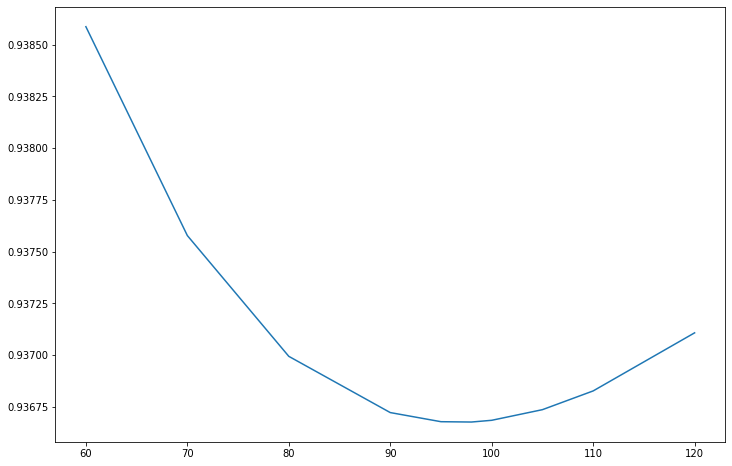

In [55]:
plt.figure(figsize = (12, 8))
# plt.plot(L2_REGS, VAL_MSES)
plt.plot(L2_REGS, VAL_R2)

In [63]:
reg = Ridge(alpha = 0.85).fit(X_train, y_train)
val_pred = reg.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
train_pred = reg.predict(X_train)
val_pred = reg.predict(X_val)

all_countries = train_subset['country_region'].append(val_subset['country_region'])
all_preds = np.append(train_pred, val_pred)
all_gt = y_train.append(y_val)

val_countries = val_subset['country_region']
countries_with_preds = pd.DataFrame(data = {
    'country' : all_countries,
    'preds' : all_preds,
    'gt': all_gt
})

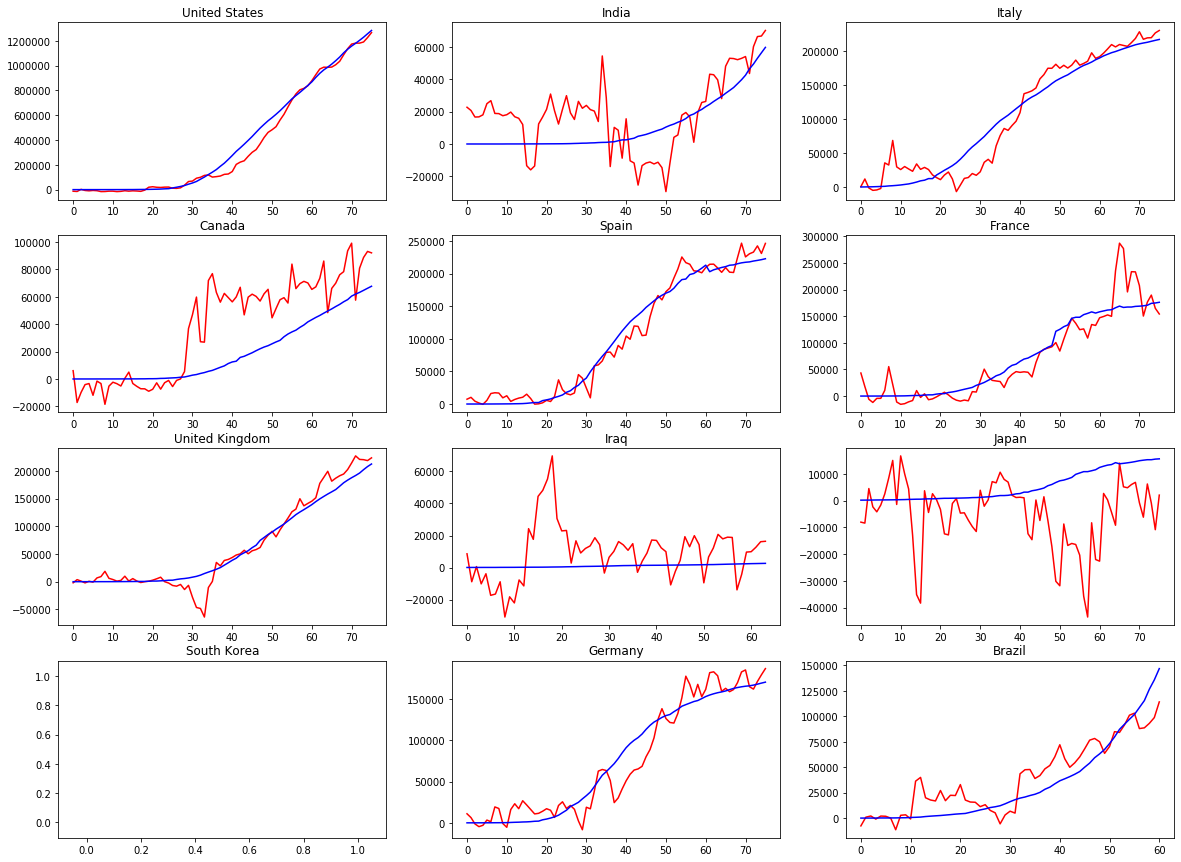

In [64]:
fig, (
    (ax11, ax12, ax13), 
    (ax21, ax22, ax23),
    (ax31, ax32, ax33),
    (ax41, ax42, ax43)
) = plt.subplots(4, 3)
# fig.suptitle('Sharing x per column, y per row')

fig.set_figwidth(20)
fig.set_figheight(15)
axes = [ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33, ax41, ax42, ax43]
countries = COUNTRIES

for country, ax in zip(countries, axes):
    country_preds = countries_with_preds[countries_with_preds['country'] == country]
    dates = np.arange(country_preds.shape[0])
    ax.plot(dates, country_preds['preds'], 'r-')
    ax.plot(dates, country_preds['gt'], 'b-')
    ax.set_title(country)
